In [1]:
import os

import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

from resnet_model import *

In [2]:
resize_shape = (156, 156)

data_dir = '/home/selimon/Desktop/AI/wdwyl_ros1/src/perception/brand_classification/data/training_validation'
print(os.listdir(data_dir))

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))


train_tfms = tt.Compose([
    tt.Resize(resize_shape),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(10),
    tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

valid_tfms = tt.Compose([
    tt.Resize(resize_shape),
    tt.ToTensor(),
    tt.Normalize(*stats)
])


# Load dataset
full_dataset = ImageFolder(data_dir)


k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

['4_pines', 'crown', 'great_northern', 'heineken']


In [3]:
batch_size = 40


def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
    
# show_batch(train_dl)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print('cuda')
        return torch.device('cuda')
    else:
        print('cpu')
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()

cuda


## Plot Functions

In [5]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

## Training Model

In [6]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

FOLD NUMBER: 1/5


/home/selimon/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetPretrained(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [0], train_loss: 1.3318, val_loss: 1.0526, val_acc: 0.6562


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1], train_loss: 0.9892, val_loss: 0.6489, val_acc: 0.8062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2], train_loss: 0.8025, val_loss: 0.4405, val_acc: 0.8500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3], train_loss: 0.8546, val_loss: 0.3243, val_acc: 0.8812


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4], train_loss: 0.7460, val_loss: 0.2886, val_acc: 0.8875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5], train_loss: 0.8431, val_loss: 0.3915, val_acc: 0.8500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6], train_loss: 0.8368, val_loss: 0.2027, val_acc: 0.9125


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7], train_loss: 0.7439, val_loss: 0.2805, val_acc: 0.9125


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8], train_loss: 0.7201, val_loss: 0.4014, val_acc: 0.8750


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9], train_loss: 0.9350, val_loss: 0.3134, val_acc: 0.9125


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10], train_loss: 0.8816, val_loss: 0.3459, val_acc: 0.9250


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11], train_loss: 0.8829, val_loss: 0.2787, val_acc: 0.9312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12], train_loss: 0.5603, val_loss: 0.2943, val_acc: 0.9187


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13], train_loss: 0.6066, val_loss: 0.4874, val_acc: 0.8562


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14], train_loss: 0.6324, val_loss: 0.2415, val_acc: 0.9187


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15], train_loss: 0.5908, val_loss: 0.2075, val_acc: 0.9438


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16], train_loss: 0.4990, val_loss: 0.1597, val_acc: 0.9437


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [17], train_loss: 0.4639, val_loss: 0.1579, val_acc: 0.9563


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [18], train_loss: 0.4783, val_loss: 0.1573, val_acc: 0.9437


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [19], train_loss: 0.4595, val_loss: 0.1807, val_acc: 0.9500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [20], train_loss: 0.4537, val_loss: 0.1613, val_acc: 0.9562


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [21], train_loss: 0.4343, val_loss: 0.1690, val_acc: 0.9438


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [22], train_loss: 0.4481, val_loss: 0.1654, val_acc: 0.9437


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [23], train_loss: 0.4832, val_loss: 0.1808, val_acc: 0.9500


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [24], train_loss: 0.4738, val_loss: 0.1838, val_acc: 0.9500


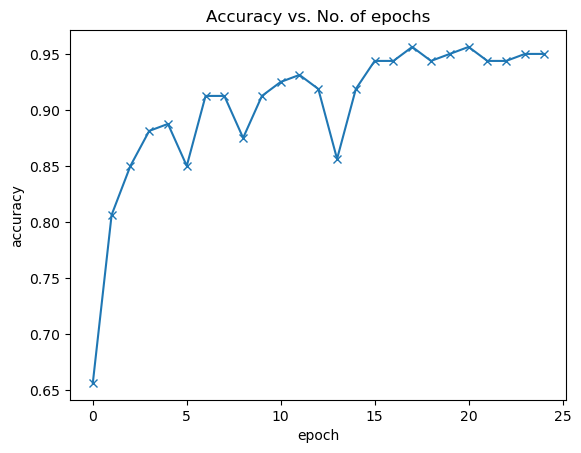

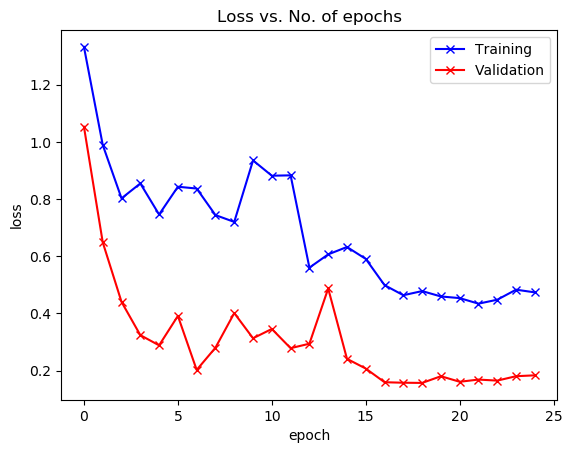

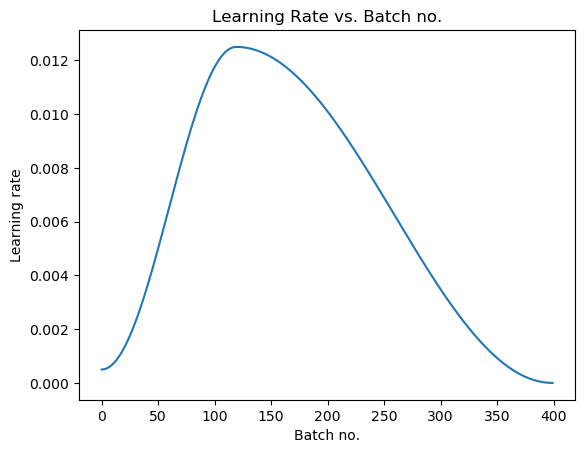

SAVING FOLD NUMBER: 1/5
FOLD NUMBER: 2/5
ResNetPretrained(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=T

/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [0], train_loss: 1.3070, val_loss: 1.0384, val_acc: 0.5312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1], train_loss: 1.0204, val_loss: 0.6266, val_acc: 0.8062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2], train_loss: 0.8764, val_loss: 0.4364, val_acc: 0.8562


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3], train_loss: 0.7191, val_loss: 0.4545, val_acc: 0.8312


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4], train_loss: 0.8787, val_loss: 0.3663, val_acc: 0.8687


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5], train_loss: 0.8310, val_loss: 0.3975, val_acc: 0.8187


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6], train_loss: 0.8105, val_loss: 0.3418, val_acc: 0.9062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7], train_loss: 0.8173, val_loss: 0.5977, val_acc: 0.8125


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8], train_loss: 1.0028, val_loss: 0.8246, val_acc: 0.7438


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9], train_loss: 1.1654, val_loss: 0.4737, val_acc: 0.8625


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10], train_loss: 0.8087, val_loss: 0.3755, val_acc: 0.8812


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11], train_loss: 0.6189, val_loss: 0.4726, val_acc: 0.8937


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12], train_loss: 0.6323, val_loss: 0.7723, val_acc: 0.8562


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13], train_loss: 0.7484, val_loss: 0.4037, val_acc: 0.8938


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14], train_loss: 0.5493, val_loss: 0.4480, val_acc: 0.8875


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15], train_loss: 0.4829, val_loss: 0.4007, val_acc: 0.8813


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16], train_loss: 0.5909, val_loss: 0.3922, val_acc: 0.9000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [17], train_loss: 0.4901, val_loss: 0.4253, val_acc: 0.9000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [18], train_loss: 0.4734, val_loss: 0.3956, val_acc: 0.8937


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [19], train_loss: 0.4712, val_loss: 0.3694, val_acc: 0.9000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [20], train_loss: 0.4419, val_loss: 0.3985, val_acc: 0.9062


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [21], train_loss: 0.4497, val_loss: 0.3483, val_acc: 0.8938


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [22], train_loss: 0.4657, val_loss: 0.3324, val_acc: 0.9000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [23], train_loss: 0.4597, val_loss: 0.3254, val_acc: 0.9000


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [24], train_loss: 0.4789, val_loss: 0.3298, val_acc: 0.8938


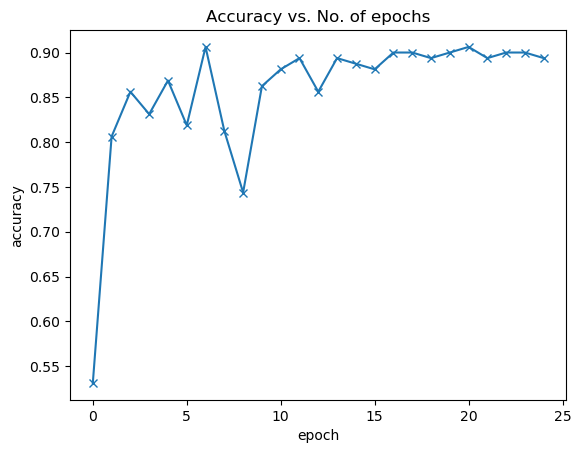

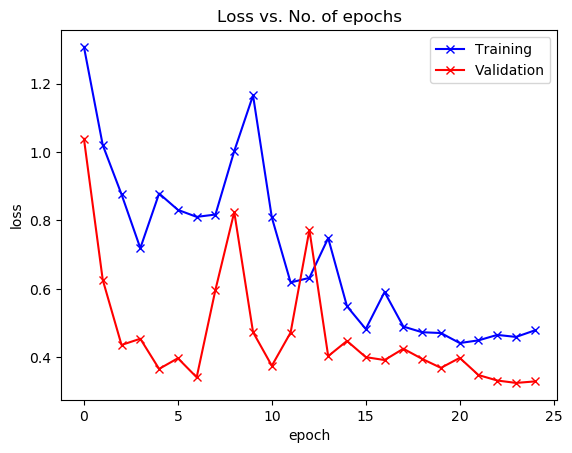

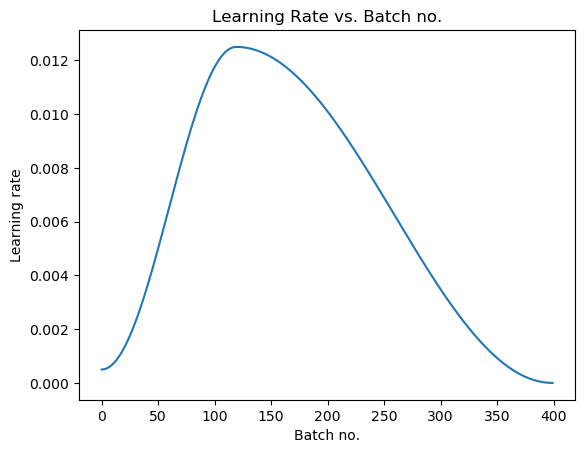

FOLD NUMBER: 3/5
ResNetPretrained(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [0], train_loss: 1.3629, val_loss: 1.0192, val_acc: 0.7688


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1], train_loss: 0.9397, val_loss: 0.5954, val_acc: 0.8687


/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/selimon/.local/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [7]:
from torch.utils.data import Subset


# Variable to keep track of the best model
best_val_acc = 0
best_model_wts = None

for fold, (train_idx, valid_idx) in enumerate(kf.split(full_dataset)):
    print(f'FOLD NUMBER: {fold + 1}/{k_folds}')

    # Create subset data for train and validation using indices from KFold
    train_ds = Subset(full_dataset, train_idx)
    valid_ds = Subset(full_dataset, valid_idx)

    # Apply transformations to train and valid sets
    train_ds.dataset.transform = train_tfms
    valid_ds.dataset.transform = valid_tfms

    # Create DataLoader objects
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=3, pin_memory=True)

    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = to_device(ResNetPretrained(4), device)
    print(model)

    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

    epochs = 25
    max_lr = 0.0125
    grad_clip = 0.085
    weight_decay = 1e-4
    opt_func = torch.optim.Adam

    # Train the model and record history for this fold
    history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                            grad_clip=grad_clip,
                            weight_decay=weight_decay,
                            opt_func=opt_func)

    # Plotting
    plot_accuracies(history)
    plt.show()
    plot_losses(history)
    plt.show()
    plot_lrs(history)
    plt.show()

    # Save the model if it has the best validation accuracy so far
    val_acc = history[-1]['val_acc']
    if val_acc > best_val_acc:
        print(f'SAVING FOLD NUMBER: {fold + 1}/{k_folds}')
        best_val_acc = val_acc
        best_model_wts = model.state_dict()

# Save the best model weights
torch.save(best_model_wts, 'resnet_model.pth')